In [3]:
import numpy as np
import pandas as pd
from torchvision import *
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import matplotlib.pyplot as plt

### Load Trained Model

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = models.resnet50(pretrained=True)
net = net.to(device)

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 6)
net.fc = net.fc.to(device)

net.load_state_dict(torch.load(os.path.join('model','landscape_resnet.pt'), map_location=torch.device(device)))

net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Load Predictions on Entire Test Dataset

In [5]:
# load test dataset

X_test = torch.load(os.path.join('data', 'X_test.pt'))
print(X_test.shape)

y_test = torch.load(os.path.join('data', 'y_test.pt'))
print(y_test.shape)

(2993, 150, 150, 3)
(2993,)


In [6]:
# predictions.csv contains predictions for each epoch of training. 
# The last epoch, where the model performance improved and the model was saved is epoch 46. 
# Thus, the following line returns the predictions of the final model

predictions = np.array(pd.read_csv('predictions.csv')['46'])
print(predictions.shape)

(2993,)


### Predictions on Single Images

In [7]:
def predict_label(net, img):
    
    preprocess = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773]),
              transforms.Resize(224)              
              ])

    img_preprocessed = preprocess(img)
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
    
    print(batch_img_tensor.shape)
    
    output = net(batch_img_tensor)
    _,prediction = torch.max(output, dim=1)
    prediction = int(prediction[0].cpu().numpy())

    return prediction

In [8]:
def decode_label(ind):
    
    label_dict = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
    decode_dict = {v: k for k, v in label_dict.items()}
    
    return decode_dict[ind]

torch.Size([1, 3, 224, 224])


NameError: name 'px' is not defined

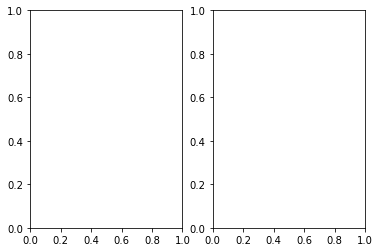

In [10]:
img = X_test[0]
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

label = y_test[0]
prediction = predict_label(net, img)
f, axarr = plt.subplots(1,2)
fig = px.imshow(img)

fig.show()